## Big Data - Sagar Agarwal

I will be looking at this paper:
Cooper, Michael J., Huseying Gulen and Michael J. Schill, 2008,  Asset growth and the cross-section of stock returns, Journal of Finance 63, 1609-1651. 

Factor discussed in this paper is Asset growth which is defined as percent change of assets at t-1 and t-2 time.
Ref: https://krannert.purdue.edu/faculty/hgulen/asset_growth.pdf


Note: These results are just for full sample data. For the orignal data results, refer to NewFactorsReplication_sa3633_hw6_orignaldataset.html

### Setting up the Dataset and Variable

Importing revelant packages

In [2]:
import os
os.chdir('C:\\Users\\dell\\Downloads\\b9334\\fire_pytools')  # Provide the new path here

In [3]:
import pandas as pd
import wrds
import time
from fire_pytools.portools.sort_portfolios import *
from fire_pytools.portools.find_breakpoints import *

Creating relevant breakpoint variables

In [4]:
import pandas as pd
from pylab import *
from matplotlib.pyplot import figure

from utils.monthly_date import *

from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios

desired_width = 10
pd.set_option('display.width', desired_width)


In [5]:
def calculate_new_factor(adata): #TODO: to be completed
    """
    Calculate asset growth
    """
    start_time = time.time()
    df = adata.copy()
    df['asset_lag']  = df.groupby('permno')['asset'].shift(1)
#    df['asset'] = df['asset'].notnull()
#    df.reset_index(level=0, inplace=True)
#    print(df[['permno', 'asset']][0:100])
    # Cumulative Return (adjusted) in 11 months
    lag_asset = df.groupby('permno')['asset_lag'].pct_change()
    return lag_asset
db = wrds.Connection(wrds_username='sagar520')  # make sure to configure wrds connector before hand.

Enter your WRDS username [dell]:sagar520
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [6]:
char_breakpoints = {'me': [0.3,0.7], 'asset_growth': [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

weightvar = 'melag'
retvar = 'retadj'

dict_factors = {'me': 'me', 'asset_growth': 'agf'}

In [30]:
### Get all data
# Annual Data
mdata = pd.read_pickle('../stock_monthly.pkl')
adata = pd.read_pickle('../stock_annual.pkl')

# Set names
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) #inv_permco
mdata.rename(columns={weightvar: 'weightvar', retvar: 'retvar'}, inplace=True)

In [31]:
adata['asset'] = adata['lt']+ adata['seq']

In [32]:
query = "SELECT caldt as date, t30ret as rf FROM crspq.mcti"
rf = db.raw_sql(query, date_cols=['date'])
rf.set_index('date', inplace=True)

In [33]:
mdata['retadj'] = mdata['retvar']
adata['asset_growth'] = calculate_new_factor(adata)

Putting filters of SHRCH, Exchange, valid returns, Market Equity>0 and no null values in variable of interest

In [34]:
# valid return
# ------------
print('Data deleted due to missing return: %f' % np.round(mdata.retvar.isnull().mean()*100, 2))
rdata = mdata[mdata.retvar.notnull()]

Data deleted due to missing return: 3.340000


Keeping the orignal dataset.

In [35]:
adata = adata[(adata['rankyear']>1965)]

In [36]:
# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

Data deleted due to shrcd: 24.710000


In [37]:
# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]

#del adata, mdata

Data deleted due to exchcd: 1.750000


In [38]:
# Portfolio Specif Filters
sortvars = [*char_breakpoints]

# Define the break point filters
# ------------------------------
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

In [39]:
# Define the sample filter
# ------------------------

sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    bp_filters[sortvar] = (sort_data[sortvar].notnull())
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0)  &(sort_data[sortvar].notnull()))

### Calculating Breakpounts

In [40]:
breakpoints = [None] * len(sortvars)
breakpoints = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    breakpoints[sortvar] = find_breakpoints(data=sort_data[bp_filters[sortvar]],
                                            quantiles={sortvar: char_breakpoints[sortvar]},
                                            id_variables=['rankyear', 'permno', 'exchcd'],
                                            exch_cd=[1]
                                            )

NYSE breakpoints were calculated for me.
NYSE breakpoints were calculated for asset_growth.


### Sort Portfolio

Sorting the dataset baset on the breakpoints calculated

In [41]:
portsorts = [None] * len(sortvars)
portsorts = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    portsorts[sortvar] = sort_portfolios(data=sort_data[sample_filters[sortvar]],
                                         quantiles={sortvar: char_breakpoints[sortvar]},
                                         id_variables=['rankyear', 'permno', 'exchcd'],
                                         breakpoints={sortvar: breakpoints[sortvar]}
                                         )

Stocks were sorted according to breakpoints, starting in 1966.0
Stocks were sorted according to breakpoints, starting in 1966.0


### Merge Portfolio

Merging the sorted dataset to monthly filtered data

In [42]:
port = portsorts['me'].copy()
for sortvar in sortvars[1:]:
    # Notice that this is an outer join
    port = port.merge(portsorts[sortvar], on=['permno', 'rankyear'], how='outer')
port_ret = pd.merge(port, rdata, on=['rankyear', 'permno'])

### Factor Calculations

Calculating the factors based on the Fama French website.

In [43]:
def wavg(group, avg_name, weight_name):
    """ Source: http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    Calculates weighted average of a column in a dataset based on weight column
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
idx = pd.IndexSlice

In [44]:
# Characteristic: ag
# --------------------
charvars = ['me','asset_growth']
ag_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
ag_ret = ag_ret.unstack(level=[1,2])
ag_ret['agf'] = ag_ret.loc[:,idx[:,'asset_growth10']].mean(axis=1) - ag_ret.loc[:,idx[:,'asset_growth1']].mean(axis=1)

In [45]:
for i in range(1,11):
    i = str(i)
    ag_ret['agf_'+i] = ag_ret.loc[:,idx[:,'asset_growth'+i]].mean(axis=1)

In [46]:
req_cols = ['agf']
for i in range(1,11):
    req_cols.extend(['agf_'+str(i)])
ag_ret[req_cols].describe()
agff = ag_ret[req_cols]

Merging all the factors into a file

In [47]:
agff.columns = [''.join(col).strip() for col in agff.columns.values]
agff.reset_index(inplace=True)

In [48]:
agff['mdate'] = agff.date.apply(monthly_date)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
ff = pd.read_csv('../ff_factors.csv')
import datetime
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4) 
    return next_month - datetime.timedelta(days=next_month.day)

ff['date'] = ff['date'].apply(lambda x: last_day_of_month(pd.to_datetime(str(x), format='%Y%m')))
ff.set_index('date', inplace=True)
ff_ret = ff/100

In [50]:
ff_ret = pd.merge(agff, ff_ret, on=['date'])
ff_ret.head(10)

date  \
0 1966-08-31   
1 1966-09-30   
2 1966-10-31   
3 1966-11-30   
4 1967-01-31   
5 1967-02-28   
6 1967-03-31   
7 1967-05-31   
8 1967-06-30   
9 1967-07-31   

        agf  \
0 -0.007206   
1  0.005049   
2  0.002038   
3  0.050981   
4 -0.017025   
5  0.035305   
6 -0.004870   
7 -0.002121   
8  0.012984   
9  0.032832   

      agf_1  \
0 -0.089209   
1 -0.035843   
2  0.000592   
3  0.015768   
4  0.161788   
5  0.016049   
6  0.060273   
7 -0.029134   
8  0.071376   
9  0.071731   

      agf_2  \
0 -0.080139   
1  0.005616   
2  0.045133   
3  0.016423   
4  0.114728   
5  0.005289   
6  0.031925   
7 -0.018911   
8  0.049959   
9  0.039176   

      agf_3  \
0 -0.073407   
1  0.037363   
2  0.031516   
3  0.026368   
4  0.090236   
5 -0.014501   
6  0.034518   
7 -0.016552   
8  0.008157   
9  0.066824   

      agf_4  \
0 -0.073746   
1 -0.012536   
2  0.026653   
3 -0.000978   
4  0.109493   
5  0.000961   
6  0.054814   
7 -0.039060   
8  0.064103   
9  0.041509   

      agf_5  \
0 -0.087097   
1 -0.018110   
2  0.044701   
3  0.027975   
4  0.111912   
5  0.015238   
6  0.085862   
7 -0.032157   
8  0.048499   
9  0.058284   

      agf_6  \
0 -0.081823   
1 -0.011992   
2  0.017414   
3  0.035265   
4  0.108467   
5  0.004215   
6  0.063455   
7 -0.022223   
8  0.026455   
9  0.074717   

      agf_7  \
0 -0.072046   
1 -0.014791   
2  0.049249   
3  0.006909   
4  0.100976   
5  0.013168   
6  0.063049   
7 -0.029569   
8  0.022362   
9  0.061055   

      agf_8  \
0 -0.099177   
1  0.002177   
2  0.050273   
3  0.028073   
4  0.115592   
5  0.009205   
6  0.036382   
7 -0.032177   
8  0.052563   
9  0.068848   

      agf_9  \
0 -0.097714   
1 -0.014933   
2  0.023548   
3  0.030532   
4  0.122151   
5  0.006026   
6  0.053165   
7 -0.007954   
8  0.038613   
9  0.064300   

     agf_10  \
0 -0.096416   
1 -0.030794   
2  0.002629   
3  0.066749   
4  0.144763   
5  0.051353   
6  0.055403   
7 -0.031255   
8  0.084359   
9  0.104563   

    mdate  \
0  196608   
1  196609   
2  196610   
3  196611   
4  196701   
5  196702   
6  196703   
7  196705   
8  196706   
9  196707   

   Mkt-RF  \
0 -0.0791   
1 -0.0106   
2  0.0386   
3  0.0140   
4  0.0815   
5  0.0078   
6  0.0399   
7 -0.0433   
8  0.0241   
9  0.0458   

    SMB_t  \
0 -0.0303   
1 -0.0119   
2 -0.0653   
3  0.0337   
4  0.0900   
5  0.0303   
6  0.0191   
7  0.0237   
8  0.0647   
9  0.0348   

    HML_t  \
0  0.0047   
1  0.0053   
2  0.0287   
3 -0.0446   
4  0.0222   
5 -0.0217   
6  0.0031   
7  0.0080   
8  0.0096   
9  0.0265   

    RMW_t  \
0  0.0005   
1 -0.0165   
2 -0.0364   
3  0.0417   
4  0.0062   
5  0.0194   
6  0.0090   
7 -0.0175   
8 -0.0064   
9  0.0051   

    CMA_t  \
0  0.0077   
1  0.0250   
2  0.0428   
3 -0.0653   
4 -0.0298   
5 -0.0094   
6 -0.0151   
7  0.0161   
8 -0.0238   
9  0.0273   

     RF_t  
0  0.0041  
1  0.0040  
2  0.0045  
3  0.0040  
4  0.0043  
5  0.0036  
6  0.0039  
7  0.0033  
8  0.0027  
9  0.0031

### Comparing with Fama/French Factors

Importing FF factors from the Fama french website and setting it up to be compared to factors calculated by me.

Sumary statistics of the dataset. 'row_t' indicates the True Fama French factor and 'row' is my factor. Also one thing to note here is that fama french has returns scaled by a 100. This is not going to effect our correlation so I dont bother dividing them by 100 to match as of now.

In [51]:
ff_ret.set_index('date', inplace=True)

ff_ret.head()

agf  \
date                   
1966-08-31 -0.007206   
1966-09-30  0.005049   
1966-10-31  0.002038   
1966-11-30  0.050981   
1967-01-31 -0.017025   

               agf_1  \
date                   
1966-08-31 -0.089209   
1966-09-30 -0.035843   
1966-10-31  0.000592   
1966-11-30  0.015768   
1967-01-31  0.161788   

               agf_2  \
date                   
1966-08-31 -0.080139   
1966-09-30  0.005616   
1966-10-31  0.045133   
1966-11-30  0.016423   
1967-01-31  0.114728   

               agf_3  \
date                   
1966-08-31 -0.073407   
1966-09-30  0.037363   
1966-10-31  0.031516   
1966-11-30  0.026368   
1967-01-31  0.090236   

               agf_4  \
date                   
1966-08-31 -0.073746   
1966-09-30 -0.012536   
1966-10-31  0.026653   
1966-11-30 -0.000978   
1967-01-31  0.109493   

               agf_5  \
date                   
1966-08-31 -0.087097   
1966-09-30 -0.018110   
1966-10-31  0.044701   
1966-11-30  0.027975   
1967-01-31  0.111912   

               agf_6  \
date                   
1966-08-31 -0.081823   
1966-09-30 -0.011992   
1966-10-31  0.017414   
1966-11-30  0.035265   
1967-01-31  0.108467   

               agf_7  \
date                   
1966-08-31 -0.072046   
1966-09-30 -0.014791   
1966-10-31  0.049249   
1966-11-30  0.006909   
1967-01-31  0.100976   

               agf_8  \
date                   
1966-08-31 -0.099177   
1966-09-30  0.002177   
1966-10-31  0.050273   
1966-11-30  0.028073   
1967-01-31  0.115592   

               agf_9  \
date                   
1966-08-31 -0.097714   
1966-09-30 -0.014933   
1966-10-31  0.023548   
1966-11-30  0.030532   
1967-01-31  0.122151   

              agf_10  \
date                   
1966-08-31 -0.096416   
1966-09-30 -0.030794   
1966-10-31  0.002629   
1966-11-30  0.066749   
1967-01-31  0.144763   

             mdate  \
date                 
1966-08-31  196608   
1966-09-30  196609   
1966-10-31  196610   
1966-11-30  196611   
1967-01-31  196701   

            Mkt-RF  \
date                 
1966-08-31 -0.0791   
1966-09-30 -0.0106   
1966-10-31  0.0386   
1966-11-30  0.0140   
1967-01-31  0.0815   

             SMB_t  \
date                 
1966-08-31 -0.0303   
1966-09-30 -0.0119   
1966-10-31 -0.0653   
1966-11-30  0.0337   
1967-01-31  0.0900   

             HML_t  \
date                 
1966-08-31  0.0047   
1966-09-30  0.0053   
1966-10-31  0.0287   
1966-11-30 -0.0446   
1967-01-31  0.0222   

             RMW_t  \
date                 
1966-08-31  0.0005   
1966-09-30 -0.0165   
1966-10-31 -0.0364   
1966-11-30  0.0417   
1967-01-31  0.0062   

             CMA_t  \
date                 
1966-08-31  0.0077   
1966-09-30  0.0250   
1966-10-31  0.0428   
1966-11-30 -0.0653   
1967-01-31 -0.0298   

              RF_t  
date                
1966-08-31  0.0041  
1966-09-30  0.0040  
1966-10-31  0.0045  
1966-11-30  0.0040  
1967-01-31  0.0043

In [52]:
ff_ret.describe()

agf  \
count  440.000000   
mean    -0.001717   
std      0.022884   
min     -0.075772   
25%     -0.015482   
50%     -0.001308   
75%      0.012348   
max      0.112658   

            agf_1  \
count  440.000000   
mean     0.010056   
std      0.060329   
min     -0.213166   
25%     -0.025947   
50%      0.011305   
75%      0.050508   
max      0.218866   

            agf_2  \
count  440.000000   
mean     0.012051   
std      0.050279   
min     -0.188679   
25%     -0.016348   
50%      0.015213   
75%      0.043076   
max      0.200573   

            agf_3  \
count  440.000000   
mean     0.010837   
std      0.047954   
min     -0.182111   
25%     -0.018653   
50%      0.014008   
75%      0.042999   
max      0.203933   

            agf_4  \
count  440.000000   
mean     0.011208   
std      0.046398   
min     -0.183527   
25%     -0.016585   
50%      0.014247   
75%      0.040732   
max      0.203477   

            agf_5  \
count  440.000000   
mean     0.011469   
std      0.046698   
min     -0.162307   
25%     -0.017320   
50%      0.014073   
75%      0.040089   
max      0.243391   

            agf_6  \
count  440.000000   
mean     0.011703   
std      0.046217   
min     -0.189818   
25%     -0.015350   
50%      0.014750   
75%      0.042519   
max      0.220944   

            agf_7  \
count  440.000000   
mean     0.011017   
std      0.048899   
min     -0.185969   
25%     -0.015967   
50%      0.013641   
75%      0.041789   
max      0.233776   

            agf_8  \
count  440.000000   
mean     0.011273   
std      0.051273   
min     -0.190384   
25%     -0.020043   
50%      0.013372   
75%      0.044350   
max      0.226185   

            agf_9  \
count  440.000000   
mean     0.010968   
std      0.055763   
min     -0.206485   
25%     -0.023261   
50%      0.013392   
75%      0.046209   
max      0.212390   

           agf_10  \
count  440.000000   
mean     0.008339   
std      0.063588   
min     -0.239696   
25%     -0.029978   
50%      0.011698   
75%      0.050544   
max      0.241385   

               mdate  \
count     440.000000   
mean   199252.468182   
std      1512.451709   
min    196608.000000   
25%    197911.750000   
50%    199211.500000   
75%    200601.250000   
max    201812.000000   

           Mkt-RF  \
count  440.000000   
mean     0.005195   
std      0.045223   
min     -0.172300   
25%     -0.021100   
50%      0.008850   
75%      0.036150   
max      0.161000   

            SMB_t  \
count  440.000000   
mean     0.002429   
std      0.032326   
min     -0.149100   
25%     -0.018100   
50%      0.000400   
75%      0.022075   
max      0.183100   

            HML_t  \
count  440.000000   
mean     0.003201   
std      0.028390   
min     -0.099900   
25%     -0.012075   
50%      0.003050   
75%      0.017025   
max      0.129000   

            RMW_t  \
count  440.000000   
mean     0.002691   
std      0.023303   
min     -0.183700   
25%     -0.008325   
50%      0.002350   
75%      0.013025   
max      0.133100   

            CMA_t  \
count  440.000000   
mean     0.002066   
std      0.020257   
min     -0.065400   
25%     -0.010525   
50%      0.000800   
75%      0.014150   
max      0.095800   

             RF_t  
count  440.000000  
mean     0.003913  
std      0.002740  
min      0.000000  
25%      0.001600  
50%      0.004050  
75%      0.005300  
max      0.013500

### Sharpe Ratios

In [60]:
ff_ret.columns
factors = ['agf', 'agf_1','agf_2', 'agf_3','agf_4','agf_5','agf_6','agf_7','agf_8','agf_9','agf_10','SMB_t','HML_t','RMW_t',
       'CMA_t']

In [61]:
print('Sharpe Ratios of the factors are as follows')
for i in factors:
    sharpe = np.mean(ff_ret[i]-ff_ret['RF_t'])/np.std(ff_ret[i])
    print(i, ':',sharpe)

Sharpe Ratios of the factors are as follows
agf : -0.24630559820716375
agf_1 : 0.10195051861606982
agf_2 : 0.16205585541868597
agf_3 : 0.1445537939385641
agf_4 : 0.1574035574918321
agf_5 : 0.1619902119907982
agf_6 : 0.16874439771684005
agf_7 : 0.14545419074327987
agf_8 : 0.14371754070264023
agf_9 : 0.1266709245184819
agf_10 : 0.0696867086658116
SMB_t : -0.045941670742863955
HML_t : -0.0251014771800941
RMW_t : -0.0525020241004208
CMA_t : -0.0912490131649922


### Correlations

I wanted to see if the new factor that we created was correlated to our previous alpha. My intuition is that it should not be highly correlated. We have learnt that if the factor is highly correlated then if makes no sense to run a regression on it.

In [55]:
sf = ['agf', 'SMB_t', 'HML_t', 'RMW_t', 'CMA_t']
ff_ret[sf].corr()[0:4][['agf', 'SMB_t', 'HML_t', 'RMW_t', 'CMA_t']]

agf  \
agf    1.000000   
SMB_t -0.035828   
HML_t -0.357955   
RMW_t  0.166734   

          SMB_t  \
agf   -0.035828   
SMB_t  1.000000   
HML_t -0.120666   
RMW_t -0.354060   

          HML_t  \
agf   -0.357955   
SMB_t -0.120666   
HML_t  1.000000   
RMW_t  0.163151   

          RMW_t  \
agf    0.166734   
SMB_t -0.354060   
HML_t  0.163151   
RMW_t  1.000000   

          CMA_t  
agf   -0.477757  
SMB_t -0.129627  
HML_t  0.705940  
RMW_t  0.039620

### Plots

Here, we see that all the decile asset growth have similar return streams. 

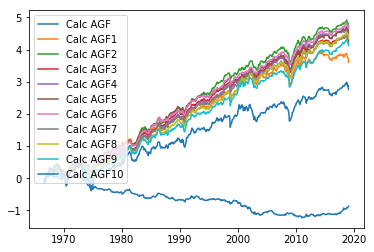

In [56]:
import matplotlib.pyplot as plt
plt.plot(np.log(1+ff_ret['agf']).cumsum(), label ='Calc AGF')
for i in range(1,11):
    plt.plot(np.log(1+ff_ret['agf_'+str(i)]).cumsum(), label ='Calc AGF'+str(i))
plt.legend(loc = 2)
plt.show()

### Comparing Alphas with Fama French

In [57]:
ff_ret['year'] = ff_ret.index
ff_ret['year'] = ff_ret['year'].map(lambda x: x.year)

In [58]:
from sklearn import linear_model
years=  [1968,1980,1991,2003]
t  = ['agf', 'agf_1','agf_2', 'agf_3','agf_4','agf_5','agf_6','agf_7','agf_8','agf_9','agf_10']
for i in range(3):
    print('Year '+str(years[i])+'-'+str(years[i+1]))
    data = ff_ret[(ff_ret['year']>years[i]) & (ff_ret['year']<=years[i+1])] 
    columns = ['RF_t', 'SMB_t', 'HML_t']
    df = data[columns]
    for j in t:
        target = data[j]
        lm = linear_model.LinearRegression()
        model = lm.fit(df,target)
        print(j,':',lm.intercept_)

Year 1968-1980
agf : -0.0020927022115558138
agf_1 : 0.028018087754648764
agf_2 : 0.027702434824315357
agf_3 : 0.02800398082972088
agf_4 : 0.029936742716566912
agf_5 : 0.03273568777116084
agf_6 : 0.03142024042550833
agf_7 : 0.028334008938027302
agf_8 : 0.028435661418389803
agf_9 : 0.030345649233551857
agf_10 : 0.025925385543092955
Year 1980-1991
agf : 0.0049297467406422685
agf_1 : 0.005777929526071483
agf_2 : 0.013096847267794077
agf_3 : 0.015442060623150792
agf_4 : 0.016281948251972243
agf_5 : 0.013875572524560509
agf_6 : 0.014640328428127554
agf_7 : 0.010226681164534783
agf_8 : 0.010865335736168843
agf_9 : 0.010358234767446031
agf_10 : 0.01070767626671373
Year 1991-2003
agf : -0.010018577982572002
agf_1 : 0.0015456077903829996
agf_2 : 0.0055341435976325685
agf_3 : 0.004126174087482564
agf_4 : 0.005224242917598374
agf_5 : 0.005179216725989681
agf_6 : 0.005461108169043685
agf_7 : -0.0007908366943805787
agf_8 : 0.003791946243333656
agf_9 : -0.0016209825330124432
agf_10 : -0.0084729701921

Even though the paper has not compared with 5 factor Fama French, the alphas are as follows:

In [59]:
for i in range(3):
    print('Year '+str(years[i])+'-'+str(years[i+1]))

    data = ff_ret[(ff_ret['year']>years[i]) & (ff_ret['year']<=years[i+1])] 
    columns = ['RF_t', 'SMB_t', 'HML_t', 'RMW_t', 'CMA_t']
    df = data[columns]
    for j in t:
        target = data[j]
        lm = linear_model.LinearRegression()
        model = lm.fit(df,target)
        print(j,':',lm.intercept_)

Year 1968-1980
agf : -0.004300593105524705
agf_1 : 0.03611381316119651
agf_2 : 0.03315656031334875
agf_3 : 0.03554562025829969
agf_4 : 0.03661863034334651
agf_5 : 0.03886772892468447
agf_6 : 0.0369803553197899
agf_7 : 0.033745079194156535
agf_8 : 0.03393419842288425
agf_9 : 0.03574559194064732
agf_10 : 0.0318132200556718
Year 1980-1991
agf : 0.006951509507945984
agf_1 : 0.01139004489239601
agf_2 : 0.017770073106710478
agf_3 : 0.01943538120859776
agf_4 : 0.020614953875830254
agf_5 : 0.01835537158758942
agf_6 : 0.019782530699435977
agf_7 : 0.015978498692876365
agf_8 : 0.0150448592690617
agf_9 : 0.01709821189958123
agf_10 : 0.018341554400341964
Year 1991-2003
agf : -0.008660445380218153
agf_1 : 0.010601953810751505
agf_2 : 0.011993097871657015
agf_3 : 0.011409081280305265
agf_4 : 0.011280804218688519
agf_5 : 0.011567439216174213
agf_6 : 0.011603592505609907
agf_7 : 0.0064231429247384435
agf_8 : 0.011698583054782264
agf_9 : 0.007548050925219428
agf_10 : 0.0019415084305333414
